In [383]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from   sklearn.linear_model import LinearRegression, LogisticRegression
from   sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.feature_selection import chi2

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.style.use('seaborn-poster')

In [384]:
king = pd.read_excel("..\data\king_county_home_sales.xlsx", index_col= "Unnamed: 0" )
king.sample(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,sqft_above,...,zipcode,lat,long,sqft_living15,sqft_lot15,renovated,view_ord,condition_ord,grade_ord,age
18918,7696620100,2015-04-22,254999,3,1.00,1580,7560,1.0,0,1000,...,98001,47.3318,-122.277,1580,7560,0,0,3,4,39
2112,2916620240,2014-06-18,264950,4,1.75,1770,9011,1.0,0,1050,...,98042,47.3646,-122.076,1410,8530,0,0,4,4,32
17798,8563050110,2014-05-22,592500,4,3.00,2170,8240,1.0,0,1370,...,98052,47.6291,-122.093,2020,7944,0,0,3,5,47
17694,6199000141,2015-03-12,349950,4,2.00,1764,15600,1.0,0,1764,...,98058,47.4318,-122.181,1490,22387,0,0,4,4,73
9711,2568300045,2014-06-25,305000,6,2.00,1900,8240,1.0,0,1200,...,98125,47.7037,-122.296,1900,8240,0,0,1,4,51
9852,5104520810,2014-08-10,378000,3,2.50,2150,11672,2.0,0,2150,...,98038,47.3515,-122.006,2150,5450,0,0,2,5,11
15298,1423700680,2015-02-26,190000,3,1.75,1390,7700,1.0,0,1390,...,98058,47.4559,-122.183,1260,7700,0,0,4,4,50
9723,263000324,2014-05-13,550000,7,4.00,3440,8100,2.0,0,3440,...,98103,47.6981,-122.349,1420,1560,0,0,2,4,45
19931,1776460110,2014-12-23,395000,4,2.75,2280,5013,2.0,0,2280,...,98019,47.7333,-121.976,2130,5121,0,0,2,5,6
11093,4054530260,2014-06-27,1820000,4,4.50,6640,53330,2.0,0,6640,...,98077,47.7283,-122.046,4620,68625,0,0,2,9,22


Here is a first attempt at a simple linear regression model using the sqft_living room of a home to model

In [385]:
# price as a function of sqfr_living room, this is just a pedigocial tool and will serve as a basis


X, y = king[['sqft_living']] , king[['price']]

# Generate train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.3, random_state=42
)

# Init, fit, score
model = LinearRegression()
model.fit(X_train, y_train)

print(f"Training score: {model.score(X_train, y_train)}")

print(f"Test score: {model.score(X, y)}")


Training score: 0.49217109776184653
Test score: 0.4926862289296692


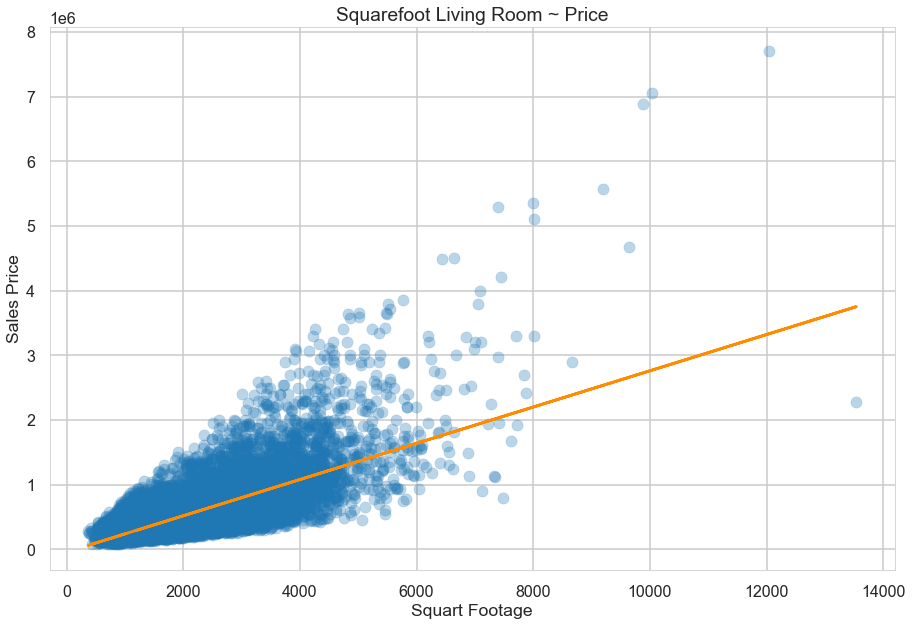

In [386]:
# plot fit
plt.scatter(king.sqft_living, king.price, alpha=0.3)
plt.plot(king.sqft_living, model.predict(king[['sqft_living']]), c='darkorange')
plt.title("Squarefoot Living Room ~ Price")
plt.xlabel("Squart Footage")
plt.ylabel("Sales Price")
plt.tight_layout()
plt.show()

Now it is time for a multi linear regression:

In [387]:
king.columns # calling all columns in order to determine what subset of columns we will use for our models
features = king[['bedrooms', 'bathrooms', 'sqft_living',
                 'sqft_lot', 'floors', 'waterfront', 'sqft_above',
                 'sqft_basement', 'lat', 'long', 'sqft_living15',
                 'sqft_lot15', 'view_ord', 'condition_ord', 'grade_ord', 'age', "renovated"]]

In [388]:
# mulit model time: (all ~ price) decided to use every column here except for yr_built since this column and age are redundant and zipcode since it is an arbitraruy number not relevant to our dataframe yet.

X, y = features, king[['price']]

# Generate train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.3, random_state=42
)


# Init, fit, score
multi_model = LinearRegression()
multi_model.fit(X_train, y_train)

print(f"Training score: {multi_model.score(X_train, y_train)}")
multi_model_score = multi_model.score(X_test, y_test)
print(f"Test score: {multi_model.score(X_test, y_test)}")

Training score: 0.7008430929351748
Test score: 0.6822292264304166


An r^2 score of 0.68 isn't bad but it isn't great either. Maybe we have some collinearity issues going on and we need to be more selective about our features. So its time to do some feature selection

In [389]:
def identify_correlated(df, threshold):
    """
    A function to identify highly correlated features.
    """
    # Compute correlation matrix with absolute values
    matrix = df.corr().abs()

    # Create a boolean mask
    mask = np.triu(np.ones_like(matrix, dtype=bool))

    # Subset the matrix
    reduced_matrix = matrix.mask(mask)

    # Find cols that meet the threshold
    to_drop = [c for c in reduced_matrix.columns if \
              any(reduced_matrix[c] > threshold)]

    return to_drop

# Thanks to this towards data science for this function: https://towardsdatascience.com/how-to-use-pairwise-correlation-for-robust-feature-selection-20a60ef7d10

In [390]:
to_drop = identify_correlated(king, .7) #proceeding with dropping these features that are highly correlated

to_drop

['price',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'sqft_above',
 'yr_built',
 'yr_renovated',
 'sqft_living15']

In [391]:
# Build feature/target arrays
X, y = king[['bedrooms','sqft_lot', 'floors', 'waterfront',
             'sqft_basement', 'sqft_living15',
             'sqft_lot15', 'view_ord', 'condition_ord', 'grade_ord', 'age', "renovated"]] , king[['price']]

# Generate train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.3, random_state=42
)


# Init, fit, score
multi_model_red = LinearRegression()
multi_model_red.fit(X_train, y_train)

print(f"Training score: {multi_model_red.score(X_train, y_train)}")
multi_model_score_red = multi_model_red.score(X_test, y_test)
print(f"Test score: {multi_model_red.score(X_test, y_test)}")

print(f"\nOur r^2 score was {multi_model_score:.04f} and our new reduced score is {multi_model_score_red:.04f} this is a large decrease in r^2 after removing features that are collinear, so lets go back to our original model with all the features.")

Training score: 0.6278784448568655
Test score: 0.5834224126620757

Our r^2 score was 0.6822 and our new reduced score is 0.5834 this is a large decrease in r^2 after removing features that are collinear, so lets go back to our original model with all the features.


So how should we proceed from here? One step is to calculate the interactions between different features.

In [392]:
king.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'sqft_above', 'sqft_basement',
       'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'renovated', 'view_ord', 'condition_ord', 'grade_ord',
       'age'],
      dtype='object')

In [393]:
y = king['price']
X = king[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront',
          'sqft_above', 'sqft_basement','lat', 'long', 'zipcode',
          'sqft_living15', 'sqft_lot15', 'renovated', 'view_ord', 'condition_ord', 'grade_ord', 'age']]

from sklearn.preprocessing import PolynomialFeatures

linear_withinteraction = PolynomialFeatures(degree = 2, interaction_only = True, include_bias = False)

X_transformed = linear_withinteraction.fit_transform(X.drop(columns= 'zipcode')) #removing zipcode column this will become evident latter when we dummy our zip code

feat_names = pd.Series(linear_withinteraction.get_feature_names())

feat_names

0           x0
1           x1
2           x2
3           x3
4           x4
        ...   
148    x13 x15
149    x13 x16
150    x14 x15
151    x14 x16
152    x15 x16
Length: 153, dtype: object

In [394]:
xs = ['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10',  'x11', 'x12', 'x13', 'x14', 'x15','x16']

columns = X.columns

map_dict = {x:y for x,y in zip(xs, columns)}

for key, value in map_dict.items():
    feat_names = feat_names.str.replace(key, value)


X_trans_df = pd.DataFrame(X_transformed)
X_trans_df.columns = feat_names

X_trans_df.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,sqft_above,sqft_basement,lat,long,...,bathrooms2 bathrooms3,bathrooms2 bathrooms4,bathrooms2 bathrooms5,bathrooms2 bathrooms6,bathrooms3 bathrooms4,bathrooms3 bathrooms5,bathrooms3 bathrooms6,bathrooms4 bathrooms5,bathrooms4 bathrooms6,bathrooms5 bathrooms6
0,3.0,1.00,1180.0,5650.0,1.0,0.0,1180.0,0.0,47.5112,-122.257,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,120.0,240.0
1,3.0,2.25,2570.0,7242.0,2.0,0.0,2170.0,400.0,47.7210,-122.319,...,0.0,2.0,4.0,64.0,0.0,0.0,0.0,8.0,128.0,256.0
2,2.0,1.00,770.0,10000.0,1.0,0.0,770.0,0.0,47.7379,-122.233,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,164.0,246.0
3,4.0,3.00,1960.0,5000.0,1.0,0.0,1050.0,910.0,47.5208,-122.393,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,200.0,200.0
4,3.0,2.00,1680.0,8080.0,1.0,0.0,1680.0,0.0,47.6168,-122.045,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,56.0,140.0


In [395]:
# X_trans_standard = X_trans_df.apply(lambda x: (x - x.mean())/x.std() )
# y_standard = (y - y.mean())/y.std()

In [396]:
# Generate train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_trans_df, y, test_size=.3, random_state=42
)


# Init, fit, score
stand_model = LinearRegression()
stand_model.fit(X_train, y_train)

print(f"Training score: {stand_model.score(X_train, y_train)}")

print(f"Testing score: {stand_model.score(X_test, y_test)}")

stand_model_score  = stand_model.score(X_test, y_test)

Training score: 0.8049935388365209
Testing score: 0.779308970859638


Now one last model except now with zip code as a dummied feature instead of as an integer value!

In [397]:
dummy_zip = pd.get_dummies(king['zipcode'], drop_first = True)


X_trans_df.join(dummy_zip)

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,sqft_above,sqft_basement,lat,long,...,98146,98148,98155,98166,98168,98177,98178,98188,98198,98199
0,3.0,1.00,1180.0,5650.0,1.0,0.0,1180.0,0.0,47.5112,-122.257,...,0,0,0,0,0,0,1,0,0,0
1,3.0,2.25,2570.0,7242.0,2.0,0.0,2170.0,400.0,47.7210,-122.319,...,0,0,0,0,0,0,0,0,0,0
2,2.0,1.00,770.0,10000.0,1.0,0.0,770.0,0.0,47.7379,-122.233,...,0,0,0,0,0,0,0,0,0,0
3,4.0,3.00,1960.0,5000.0,1.0,0.0,1050.0,910.0,47.5208,-122.393,...,0,0,0,0,0,0,0,0,0,0
4,3.0,2.00,1680.0,8080.0,1.0,0.0,1680.0,0.0,47.6168,-122.045,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,3.0,2.50,1530.0,1131.0,3.0,0.0,1530.0,0.0,47.6993,-122.346,...,0,0,0,0,0,0,0,0,0,0
21593,4.0,2.50,2310.0,5813.0,2.0,0.0,2310.0,0.0,47.5107,-122.362,...,1,0,0,0,0,0,0,0,0,0
21594,2.0,0.75,1020.0,1350.0,2.0,0.0,1020.0,0.0,47.5944,-122.299,...,0,0,0,0,0,0,0,0,0,0
21595,3.0,2.50,1600.0,2388.0,2.0,0.0,1600.0,0.0,47.5345,-122.069,...,0,0,0,0,0,0,0,0,0,0


In [398]:
# X_trans_df_norm= X_trans_df.apply(lambda x: (x - x.mean())/x.std() )
# y_standard = (y - y.mean())/y.std()

In [399]:
# Generate train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_trans_df, y, test_size=.3, random_state=42
)


# Init, fit, score
norm_dummied_model = LinearRegression()
norm_dummied_model.fit(X_train, y_train)

print(f"Training score: {norm_dummied_model.score(X_train, y_train)}")

print(f"Testing score: {norm_dummied_model.score(X_test, y_test)}")

norm_dummied_model_score  = norm_dummied_model.score(X_test, y_test)

Training score: 0.8049935388365209
Testing score: 0.779308970859638


In [418]:
stand_model_score  == norm_dummied_model_score

True

One last last model

In [401]:
king.columns # calling all columns in order to determine what subset of columns we will use for our models
features = king[['bedrooms', 'bathrooms', 'sqft_living',
                 'sqft_lot', 'floors', 'waterfront', 'sqft_above',
                 'sqft_basement', 'sqft_living15', 'lat', 'long',
                 'sqft_lot15', 'view_ord', 'condition_ord', 'grade_ord', 'age', "renovated"]]

In [402]:
features = features.join(dummy_zip)

X, y = features, king[['price']]

# Generate train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.3, random_state=42
)


# Init, fit, score
multi_model = LinearRegression()
multi_model.fit(X_train, y_train)

print(f"Training score: {multi_model.score(X_train, y_train)}")
multi_model_score = multi_model.score(X_test, y_test)
print(f"Test score: {multi_model.score(X_test, y_test)}")


Training score: 0.8110954608535188
Test score: 0.7974196821510084


In [417]:
# from arcgis.geocoding import reverse_geocode
# from arcgis.geometry import Geometry
# from arcgis.gis import GIS
# import pandas as pd
#
# gis = GIS("http://www.arcgis.com", "Pedro_Velazquez_LearnArcGIS", "aGVseN88W9_d*EZ")
#
# def get_zip(df, lon_field, lat_field):
#     location = reverse_geocode((Geometry({"x":float(df[lon_field]), "y":float(df[lat_field]), "spatialReference":{"wkid": 4326}})))
#     return location['address']['Postal']


# df1["zipcode"] = df1.apply(get_zip, axis=1, lat_field='latitude', lon_field='longitude')